In [1]:
import pandas as pd 
import numpy as np

# loading the dataset for trying some plots and getting insights
covid19 = pd.read_csv("./data/intensivData/newRKi.csv", parse_dates=["Meldedatum", "Refdatum"], dayfirst=False)

covid19.head()

,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,Meldedatum,IdLandkreis,Datenstand,...,NeuerTodesfall,Refdatum,NeuGenesen,AnzahlGenesen,IstErkrankungsbeginn,Altersgruppe2,BelegteBetten,FreieBetten,Notfallreserve,COVID-19-Faelle
0,1,Schleswig-Holstein,SK Flensburg,A00-A04,M,1,0,2020-09-30,1001,"19.10.2020, 00:00 Uhr",...,-9,2020-09-30,0,1,0,Nicht übermittelt,636.0,412.0,286.0,2.0
1,1,Schleswig-Holstein,SK Flensburg,A00-A04,W,1,0,2020-08-24,1001,"19.10.2020, 00:00 Uhr",...,-9,2020-08-24,0,1,0,Nicht übermittelt,588.0,461.0,286.0,2.0
2,1,Schleswig-Holstein,SK Flensburg,A00-A04,W,1,0,2020-09-26,1001,"19.10.2020, 00:00 Uhr",...,-9,2020-09-26,0,1,0,Nicht übermittelt,627.0,417.0,287.0,5.0
3,1,Schleswig-Holstein,SK Flensburg,A05-A14,M,1,0,2020-09-25,1001,"19.10.2020, 00:00 Uhr",...,-9,2020-09-21,0,1,1,Nicht übermittelt,626.0,418.0,288.0,4.0
4,1,Schleswig-Holstein,SK Flensburg,A05-A14,M,1,0,2020-09-26,1001,"19.10.2020, 00:00 Uhr",...,-9,2020-09-21,0,1,1,Nicht übermittelt,627.0,417.0,287.0,5.0


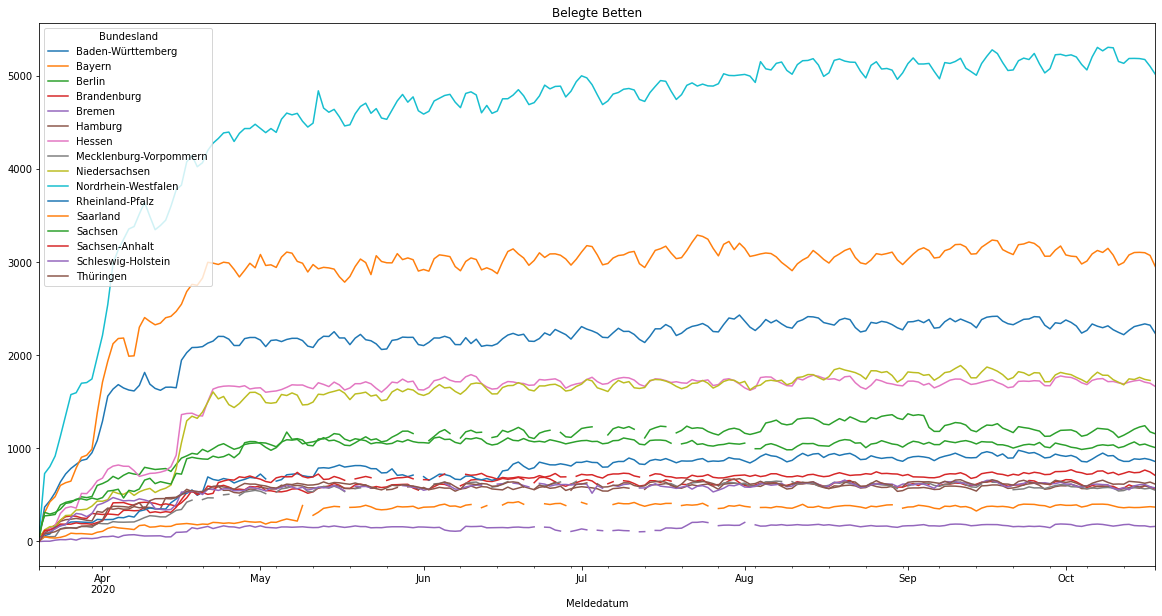

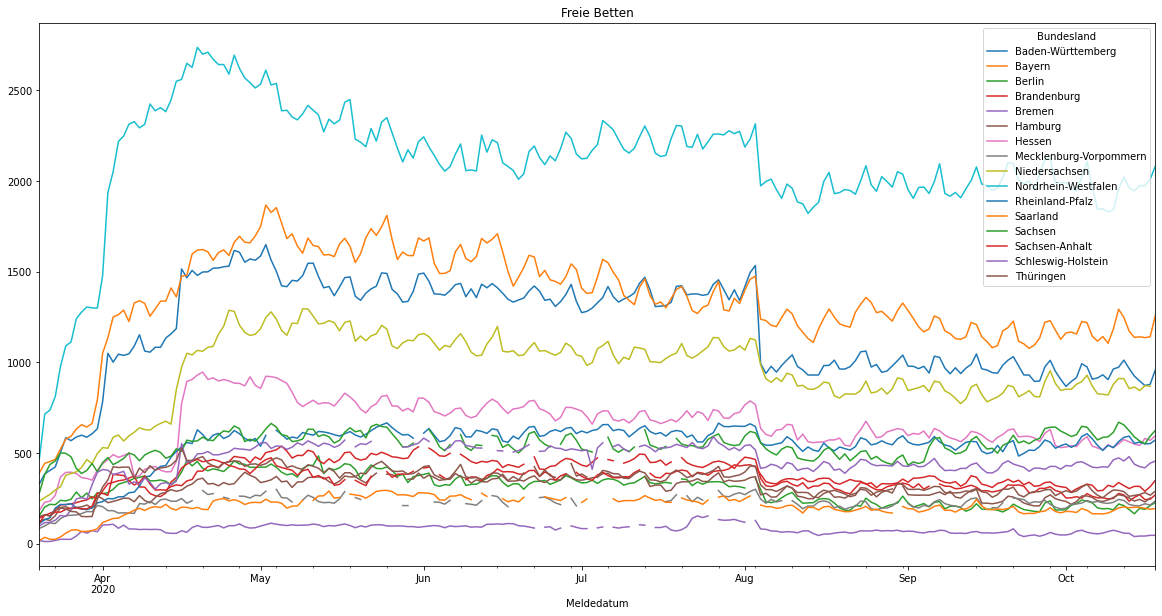

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# plotting the free and used intesive care bed numbers

covid19[["Bundesland", "Meldedatum", "BelegteBetten"]]

df_bundesland_count = covid19[["Bundesland", "Meldedatum", "BelegteBetten", "FreieBetten"]]

df_bundesland_count = df_bundesland_count.dropna()

df_bundesland_count = df_bundesland_count.groupby(["Bundesland", "Meldedatum"]).max()

belegte_betten = df_bundesland_count.reset_index()[["Meldedatum", "Bundesland", "BelegteBetten"]]
belegte_betten = belegte_betten.pivot(index="Meldedatum", columns="Bundesland", values="BelegteBetten")

freie_betten = df_bundesland_count.reset_index()[["Meldedatum","Bundesland", "FreieBetten"]]
freie_betten = freie_betten.pivot(index="Meldedatum", columns="Bundesland", values="FreieBetten")


belegte_betten.plot()
plt.title("Belegte Betten")
fig = plt.gcf()
fig.set_size_inches(20,10)

freie_betten.plot()
plt.title("Freie Betten")
fig = plt.gcf()
fig.set_size_inches(20,10)

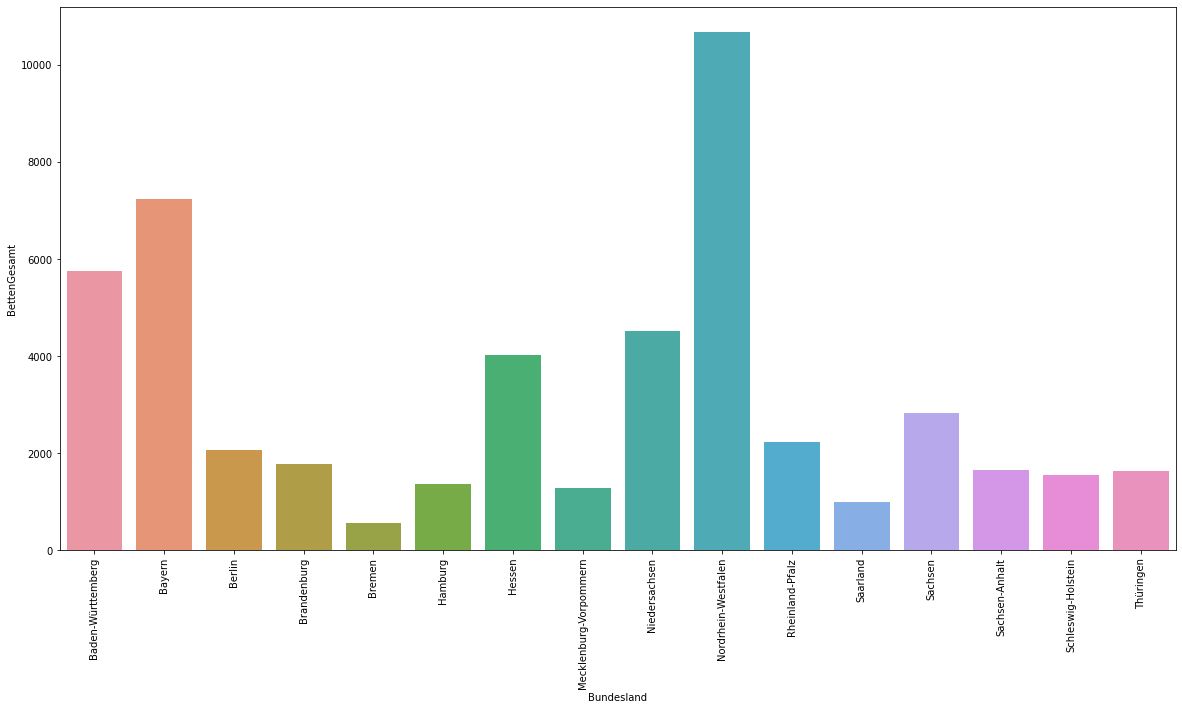

In [3]:
# plotting the sum up number of possible beds for each state

df_bundesland_count = covid19[["Bundesland", "Meldedatum", "BelegteBetten", "FreieBetten", "Notfallreserve"]]

df_bundesland_count = df_bundesland_count.dropna()
df_bundesland_count = df_bundesland_count.groupby(["Bundesland"]).max()

df_bundesland_count["BettenGesamt"] = df_bundesland_count["BelegteBetten"] + df_bundesland_count["FreieBetten"] + df_bundesland_count["Notfallreserve"]
df_bundesland_count = df_bundesland_count.reset_index()

sns.barplot(x="Bundesland", y="BettenGesamt", data=df_bundesland_count)
plt.xticks(rotation=90)
fig = plt.gcf()
fig.set_size_inches(20,10)

## Build the Model

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.base import TransformerMixin

# building the model

num_transformer = Pipeline([
    ("scaler", StandardScaler())
])

cat_transfomer = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_transformer, ["Altersgruppe", "FreeBedPercentage", "Notfallreserve"]),
    ("cat", cat_transfomer, ["Bundesland", "Landkreis", "Geschlecht"])
])

model = Pipeline([
    ("pre", preprocessor),
    ("clf", LogisticRegression())
    # ("clf", LinearSVC(class_weight='balanced'))
])

# build the grid-search parameters
gs_params = [
     {
         'clf' : [LogisticRegression()],
         'clf__penalty' : ['l1', 'l2'],
         'clf__C' : np.logspace(0, 4, 10)
     },
    {
        'clf' : [LinearSVC()],
        'clf__class_weight' : ['balanced'],
        'clf__loss' : ['hinge', 'squared_hinge'],
        'clf__C' : [1.0, 2.0, 4.0, 8.0]
    },
     {
         'clf' : [RandomForestClassifier()],
         'clf__n_estimators' : [10, 20, 50, 100],
         'clf__criterion' : ['gini', 'entropy']
     }
]

In [5]:
import modules.DataLoader as DataLoader

%load_ext autoreload
%autoreload 2

# loading the training data

features = ["Bundesland", "Landkreis", "Altersgruppe", "Geschlecht", "Meldedatum", "BelegteBetten", "FreieBetten", "Notfallreserve", "COVID-19-Faelle" ,"Deathcase"]

covid19, features = DataLoader.load_covid19_for_deathcase(features=features, cleaned=True, intensivBedData=True)

covid19[["FreieBetten", "BelegteBetten", "FreeBedPercentage", "FullBedCovidPercentage"]]

,FreieBetten,BelegteBetten,FreeBedPercentage,FullBedCovidPercentage
0,412.0,636.0,0.393130,0.003145
1,461.0,588.0,0.439466,0.003401
2,417.0,627.0,0.399425,0.007974
3,418.0,626.0,0.400383,0.006390
4,417.0,627.0,0.399425,0.007974
...,...,...,...,...
278784,291.0,615.0,0.321192,0.026016
278785,421.0,616.0,0.405979,0.069805
278786,428.0,607.0,0.413527,0.065898
278788,370.0,621.0,0.373360,0.020934


  Training-Data :
	X_train :  (176518, 6)
	y_train :  (176518,)

   Testing-Data :
	X_test  :  (44130, 6)
	y_test  :  (44130,)

Training model ...
Shape of data:  (176518, 6)
Fitting 5 folds for each of 36 candidates, totalling 180 fits
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    2.9s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    3.5s
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    7.1s
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    8.1s
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:   10.9s
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:   13.0s
[Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:   16.0s
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:   19.3s
[Parallel(n_jobs=12)]: Done  89 tasks      | elapsed:   21.7s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:   42.9s
[Parallel(n_jobs=12)]: Done 121 tasks      | elapsed:  1.6min
[Par

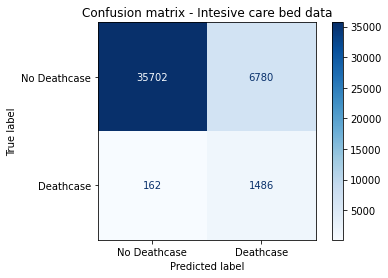

In [6]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, plot_confusion_matrix, accuracy_score

features = ["Bundesland", "Landkreis", "Altersgruppe", "Geschlecht", "FreeBedPercentage", "Notfallreserve", "Deathcase"]

X_train, X_test, y_train, y_test = train_test_split(
    covid19[features[:-1]], 
    covid19[features[-1]],
    test_size=0.2,
    random_state=42)

print("  Training-Data :")
print("\tX_train : ", X_train.shape)
print("\ty_train : ", y_train.shape)
print("\n   Testing-Data :")
print("\tX_test  : ", X_test.shape)
print("\ty_test  : ", y_test.shape)

print("\nTraining model ...")
print("Shape of data: ", X_train[features[:-1]].shape)

clf = GridSearchCV(model, gs_params, cv=5, n_jobs=12, scoring="balanced_accuracy", verbose=10)

best_model = clf.fit(X_train, y_train)

print(best_model.best_estimator_)

scores = cross_val_score( best_model.best_estimator_, X_train, y_train, cv=5, n_jobs=12, scoring="balanced_accuracy")

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# And predicting on the test dataset
print("\nPredicting ...")
y_pred = best_model.best_estimator_.predict(X_test)

print("Accuracy: {0:.2f}".format(accuracy_score(y_pred=y_pred, y_true=y_test)))

print(classification_report(y_test, y_pred, target_names=["No Deathcase", "Deathcase"]))
plot_confusion_matrix(best_model.best_estimator_, X_test, y_test, display_labels=["No Deathcase", "Deathcase"], cmap=plt.cm.Blues)
plt.title("Confusion matrix - Intesive care bed data")
plt.show()

  Training-Data :
	X_train :  (176518, 6)
	y_train :  (176518,)

   Testing-Data :
	X_test  :  (44130, 6)
	y_test  :  (44130,)

Training model ...
Shape of data:  (187304, 4)

Predicting ...
Accuracy: 0.86 (+/- 0.01)
Accuracy: 0.83
              precision    recall  f1-score   support

No Deathcase       1.00      0.83      0.90     42482
   Deathcase       0.17      0.91      0.28      1648

    accuracy                           0.83     44130
   macro avg       0.58      0.87      0.59     44130
weighted avg       0.96      0.83      0.88     44130



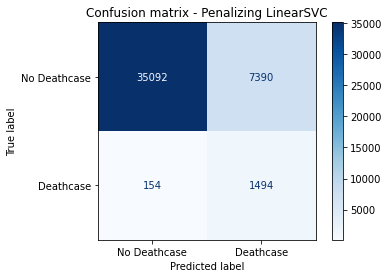

In [7]:
from sklearn.svm import LinearSVC
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split

# building the old model for the RP-Curve

covid19, features = DataLoader.load_covid19_for_deathcase(cleaned=True)

X_train_old, X_test_old, y_train_old, y_test_old = train_test_split(
    covid19[features[:-2]], 
    covid19[features[-1]],
    test_size=0.2,
    random_state=42)

print("  Training-Data :")
print("\tX_train : ", X_train.shape)
print("\ty_train : ", y_train.shape)
print("\n   Testing-Data :")
print("\tX_test  : ", X_test.shape)
print("\ty_test  : ", y_test.shape)

X_train_pen, y_train_pen = X_train_old, y_train_old

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

num_transformer = Pipeline([
    ("scaler", StandardScaler())
])

cat_transfomer = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_transformer, ["Altersgruppe"]),
    ("cat", cat_transfomer, ["Bundesland", "Landkreis", "Geschlecht"])
])

model = Pipeline([
    ("pre", preprocessor),
    ("clf", LogisticRegression())
])

model_pen = Pipeline([
    ("pre", preprocessor),
    ("clf", LinearSVC(class_weight='balanced'))
])

print("\nTraining model ...")
print("Shape of data: ", X_train_pen[["Bundesland", "Landkreis", "Altersgruppe", "Geschlecht"]].shape)
model_pen.fit(X_train_pen[["Bundesland", "Landkreis", "Altersgruppe", "Geschlecht"]], y_train_pen)

# And predicting on the test dataset
print("\nPredicting ...")
y_pred_pen = model_pen.predict(X_test)

scores = cross_val_score(model_pen, X_train_pen, y_train_pen, cv=5, n_jobs=12, scoring="balanced_accuracy")
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

print("Accuracy: {0:.2f}".format(accuracy_score(y_pred=y_pred_pen, y_true=y_test)))
print(classification_report(y_test, y_pred_pen, target_names=["No Deathcase", "Deathcase"]))
plot_confusion_matrix(model_pen, X_test, y_test, display_labels=["No Deathcase", "Deathcase"], cmap=plt.cm.Blues)
plt.title("Confusion matrix - Penalizing LinearSVC")
plt.show()

Text(0.5, 1.0, 'RP-Curves')

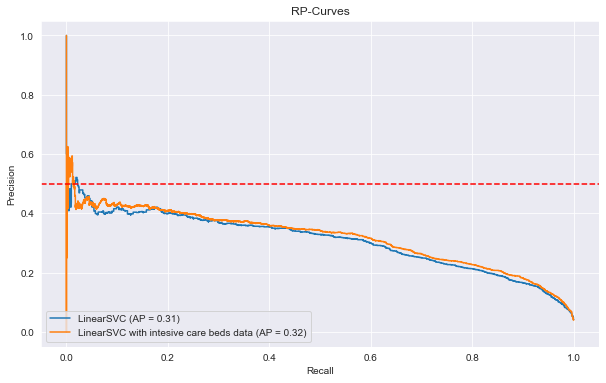

In [8]:
from sklearn.metrics import plot_precision_recall_curve
import seaborn as sns
sns.set_style("darkgrid")

plot_precision_recall_curve(model_pen, X_test_old, y_test_old, ax= plt.gca(), name="LinearSVC")
plot_precision_recall_curve(best_model.best_estimator_, X_test, y_test, ax=plt.gca(), name="LinearSVC with intesive care beds data")

plt.axhline(y=0.5, color="red", linestyle='--', label='No Skill')

fig = plt.gcf()
fig.set_size_inches(10, 6)
plt.title("RP-Curves")